Name: Yile Wang

netid: yxw190015

In [8]:
import networkx as nx
import sys
sys.path.append('../d3networkx/')
import d3networkx as d3nx
from d3graph import D3Graph, D3DiGraph
from numpy import *
from numpy.linalg import eig,norm
import matplotlib.pyplot as plt
plt.ioff()
from time import time
from copy import deepcopy
import asyncio
import colorsys
from sklearn import preprocessing

[1]:  "2pts: Correct submission (files, file type, file naming)." . `check`  
[2]:  "6pts: Discuss the effect of the diffusion parameter C." .   `check` .   
[3]:  "20pts: Convergence plot of diffusion process." .   
[4]:  "20pts: SI plot - at least one plot for each network and 3 different beta values for one network" .  
[5]:  "8pts: Discuss the effect of the beta parameter." .   
[6]:  "20pts: SIR plot - at least one plot for each network and 3 different gamma values for one network" .   
[7]:  "8pts: Discuss the effect of the gamma parameter relative to the critical value." .   
[8]:  "18pts: Plots of activation/infection for each node comparing influence (two ways) and SIR." .   

The following functions assist in coloring nodes based on the value of the state at each node. You will only need to use `color_by_value` - the rest of the functions are helper functions that are used behind the scenes.

In [67]:
def RGBToHTMLColor(rgb_tuple):
    """ convert an (R, G, B) tuple to #RRGGBB """
    hexcolor = '#%02x%02x%02x' % rgb_tuple
    # that's it! '%02x' means zero-padded, 2-digit hex values
    return hexcolor

def HTMLColorToRGB(colorstring):
    """ convert #RRGGBB to an (R, G, B) tuple """
    colorstring = colorstring.strip()
    if colorstring[0] == '#': colorstring = colorstring[1:]
    if len(colorstring) != 6:
        raise ValueError("input #%s is not in #RRGGBB format" % colorstring)
    r, g, b = colorstring[:2], colorstring[2:4], colorstring[4:]
    r, g, b = [int(n, 16) for n in (r, g, b)]
    return (r, g, b)

def color_interp(color1,color2,v,m=0,M=1):
    c1 = array(HTMLColorToRGB(color1))
    c2 = array(HTMLColorToRGB(color2))
    if v > M:
        c = tuple(c2)
    elif v <= m:
        c = tuple(c1)
    else:
        c = tuple( c1 + (c2-c1)/(M-m)*(v-m) ) # linear interpolation of color
        #c = tuple( rint( c1 + (c2-c1)*(1 - exp(-2*(v-m)/(M-m))) ) ) # logistic interpolation of color
        c = (int(c[0]),int(c[1]),int(c[2]))
    return RGBToHTMLColor(c)

def color_by_value(d3,G,x,color1='#FFFFFF',color2='#F57878'):  #color1='#77BEF5'
    interactive = d3.interactive
    d3.set_interactive(False)
    m = 0
    M = 1#0.5
    for n in G.nodes():
        d3.stylize_node(n, d3nx.node_style(size=5,stroke='#494949',fill=color_interp(color1,color2,x[G.node_index(n)],m,M)))
    d3.update()
    d3.set_interactive(interactive)

## Load the network

In [9]:
network = 'dolphins'
#network = 'train'
#network = 'macaque'

G = D3Graph( nx.read_weighted_edgelist(network+'.edgelist',create_using=nx.Graph) )

A = array(nx.adjacency_matrix(G).todense().T)
N = G.number_of_nodes()

In [4]:
d3 = await d3nx.create_d3nx_visualizer(interactive=False,
                                       node_dstyle=d3nx.node_style(size=5,fill='#FFFFFF',stroke='#494949'),
                                       edge_dstyle=d3nx.edge_style(stroke_width=1.25))

websocket server started...

networkx connected...

In [5]:
d3.port

7685

visualizer connected...

In [6]:
d3.clear()
d3.set_graph(G)
d3.update()
d3.set_interactive(True)

## Diffusion

In [18]:
dt = 0.02 # the "infinitesimal" size steps we take to integrate
T = 6 # the end of the simulation time
time = linspace(0,T,int(T/dt)) # the array of time points spaced by dt

Simulating diffusion...

In [86]:
x = zeros(N)
x[0] = 1
color_by_value(d3,G,x)
C=1 # C is the diffusion constant

def dxdt(A, x, C):
    dx_nodes = zeros(N)
    for i in range(N):
        xi_sum = []
        for j in range(N):
            xi_one = A[j,i] * (x[j] - x[i])
            xi_sum.append(xi_one)
        dx_nodes[i] = C * sum(xi_sum)
    return dx_nodes

for i,t in enumerate(time):
    x += dt*dxdt(A,x,C)
    color_by_value(d3,G,x*100)  # update the visualizer
    await asyncio.sleep(0.1) # wait a little bit so the visualizer has time to update


### Make a comment about this:

When I used different diffusion constant `C`, the speed of diffusion will be different from x[0] node to all other nodes. If the `C` is 1, the diffusion time from one node to the whole network is 8 sec. However, if `C` is 10, the diffusion time is only 1.5 sec. 

### Make a plot of distance between state x and equilibrium

when time gets large, the equilibrium was related to the eigenvectors of the Laplacian matrix. reuse code from centrality to calculate the eigenvectors of the module.

In [ ]:
# calculate the eigenvector of the network
eigencentrality_vector = [i for i in nx.eigenvector_centrality(G).values()]

In [ ]:
plt.figure()
plt.plot(time,) # replace xvalue and yvalue with what you want to plot
plt.xlabel('t')
plt.ylabel('y axis label') # change this label
plt.show()

## SI Model

Simulating SI model...  
Make a plot of the expected fraction of infected people over time using a SI infection model.  
Ajust to see how it effects the evolution


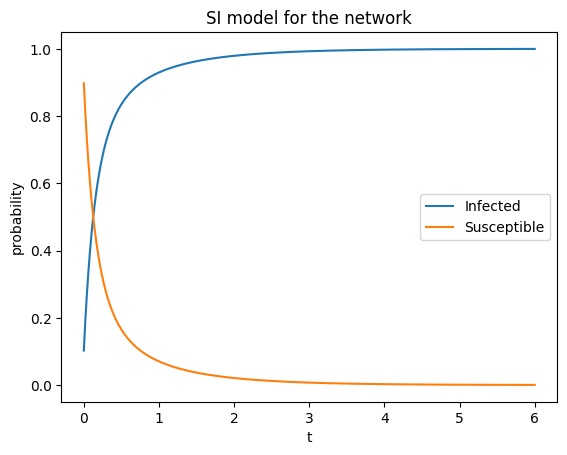

In [57]:
# calculate the SI model for the network
beta = 1
# x is the fraction of infected nodes
# 1-x is the fraction of susceptible nodes

x = zeros(N)
s = 1- x

history_S = []
history_I = []
for i,t in enumerate(time):
    for xi in range(N):
        neighbours_list = [xj for xj in where(A[:,xi]>0)]
        si = 1 - x[xi]
        dxidt = sum([beta * si * A[xj, xi] for xj in neighbours_list])
        x[xi] += dxidt*dt
        s[xi] = 1 - x[xi]
    history_S.append(mean(s))
    history_I.append(mean(x))


plt.plot(time, history_I, label = 'Infected')
plt.plot(time, history_S, label = 'Susceptible')
plt.xlabel('t')
plt.ylabel('probability')
plt.title('SI model for the network')
plt.legend()
plt.show()

## SIR Model

Simulating SIR model...  
plot 
describe and explain the effect. 

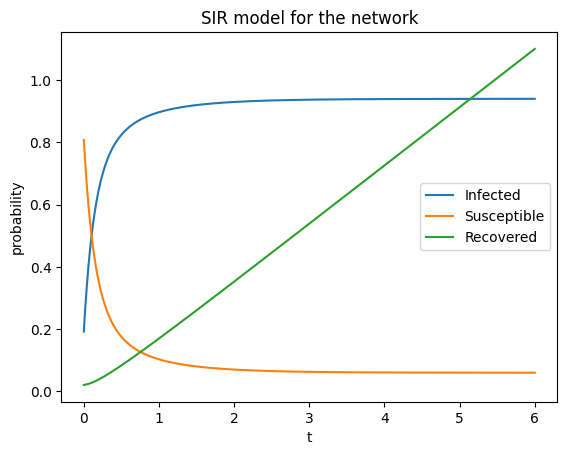

In [56]:
# calculate the SIR model for the network
beta = 1
gamma = 0.2
# x is the fraction of infected nodes
# 1-x is the fraction of susceptible nodes

x = ones(N)*0.1
s = 1- x
r = gamma * x

history_S = []
history_I = []
history_R = []
for i,t in enumerate(time):
    for xi in range(N):
        neighbours_list = [xj for xj in where(A[:,xi]>0)]
        si = 1 - x[xi]
        dxidt = sum([beta * si * A[xj, xi] for xj in neighbours_list]) - gamma * x[xi]
        dridt = gamma * x[xi]
        x[xi] += dxidt*dt
        s[xi] = 1 - x[xi]
        r[xi] += dridt*dt
    history_S.append(mean(s))
    history_I.append(mean(x))
    history_R.append(mean(r))


plt.plot(time, history_I, label = 'Infected')
plt.plot(time, history_S, label = 'Susceptible')
plt.plot(time, history_R, label = 'Recovered')
plt.xlabel('t')
plt.ylabel('probability')
plt.title('SIR model for the network')
plt.legend()
plt.show()

## Independent Cascade

The following function implements an influence cascade model on the graph `G` and initial active node set `x` with the same probability `p` to activate a neighbor node along each edge.

In [60]:
# G: Graph
# p: uniform probability to activate across an edge
# x: initial active seed set (as a list/array)
def influence_cascade(G,p,x):
    G = deepcopy(G)
    x = deepcopy(x)
    activated_nodes = set([])
    for i,xi in enumerate(x):
        if xi > 0:
            activated_nodes.add(G.node_by_index(i))

    while len(activated_nodes) > 0:
        newly_activated = set([])
        for u in activated_nodes:
            x[G.node_index(u)] = 1
            nbrs = G.neighbors(u)
            to_rm = set([])
            for v in nbrs:
                if random.random() <= p:
                    newly_activated.add(v)
                to_rm.add((u,v))
            G.remove_edges_from(to_rm)
        activated_nodes = newly_activated
        #print sum(x)
    return x

Repeating the influence cascade many times...

In [76]:
G.node_index('6')

3

In [80]:
# a random subset of nodes are initially active
initial_activated_nodes = random.sample(list(G.nodes), k=10)
initial_activated_nodes = [int(i) for i in initial_activated_nodes]
xx = zeros((N, 1000))
for t in range(1000):
    xx[:, t] = influence_cascade(G, 0.1, initial_activated_nodes)
x = mean(x, axis=1)

print(x)




IndexError: list assignment index out of range

Using a percolation approach...